In [1]:
## ALL Package
import os
import shutil
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, ClassLabel, Image, Value
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [4]:
# Have a quick look at our original dataset
import os

def count_images_in_folders(base_path):
    """
    Counts the number of images in each sub-folder under a base path.
    
    Args:
        base_path (str): Path to the main directory containing train and validation folders.
    
    Returns:
        None: Prints the counts for each sub-folder.
    """
    try:
        # Loop through 'train' and 'validation' folders
        for folder_type in ['training', 'validation']:
            folder_path = os.path.join(base_path, folder_type)
            print(f"\nFolder: {folder_type.upper()}")
            
            # Check if the folder exists
            if not os.path.exists(folder_path):
                print(f"Folder '{folder_path}' does not exist. Skipping...")
                continue
            
            # Loop through sub-folders
            for sub_folder in os.listdir(folder_path):
                sub_folder_path = os.path.join(folder_path, sub_folder)
                
                if os.path.isdir(sub_folder_path):
                    # Count files (images) in the sub-folder
                    image_count = len([f for f in os.listdir(sub_folder_path) 
                                       if os.path.isfile(os.path.join(sub_folder_path, f))])
                    print(f"  {sub_folder}: {image_count} images")
                else:
                    print(f"  Skipping non-folder item: {sub_folder}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Replace this with the path to your 'data3a' directory
base_path = "data3a"
count_images_in_folders(base_path)


Folder: TRAINING
  Skipping non-folder item: .DS_Store
  02-moderate: 463 images
  01-minor: 452 images
  03-severe: 468 images

Folder: VALIDATION
  02-moderate: 75 images
  01-minor: 82 images
  03-severe: 91 images


## Data augmentation

In [1]:
import os
import shutil
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
data3a_path = 'data3a'  # This is the dataset download from Kaggle 
augmented_path = 'augmented_data3a'  # Path to save augmented dataset
data_prep_path = 'data_prep'  # Final path for split datasets

# Create directories for augmented dataset
os.makedirs(augmented_path, exist_ok=True)

# Define augmentations
augmentation_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),  # Flip horizontally
    transforms.RandomVerticalFlip(p=1.0),    # Flip vertically
    transforms.RandomRotation(30),           # Rotate by 30 degrees
    transforms.RandomRotation(90),           # Rotate by 90 degrees
]

def augment_and_save(input_dir, output_dir):
    # Iterate through subfolders
    for subfolder in os.listdir(input_dir):
        subfolder_path = os.path.join(input_dir, subfolder)
        if os.path.isdir(subfolder_path):
            # Create corresponding folder in output_dir
            output_subfolder = os.path.join(output_dir, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)

            # Process image files in the subfolder
            for img_name in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, img_name)

                # Skip directories or non-image files
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                    continue

                try:
                    with Image.open(img_path) as img:
                        # Save original image
                        img.save(os.path.join(output_subfolder, f"{os.path.splitext(img_name)[0]}_original.jpg"))

                        # Apply each augmentation and save the result
                        for idx, transform in enumerate(augmentation_transforms):
                            augmented_img = transform(img)  # Apply transformation directly
                            augmented_img.save(os.path.join(output_subfolder, f"{os.path.splitext(img_name)[0]}_aug_{idx}.jpg"))

                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

# Augment both training and validation folders
augment_and_save(os.path.join(data3a_path, 'training'), os.path.join(augmented_path, 'training'))
augment_and_save(os.path.join(data3a_path, 'validation'), os.path.join(augmented_path, 'validation'))

# Split augmented training data into training and validation
train_augmented_path = os.path.join(augmented_path, 'training')
val_augmented_path = os.path.join(augmented_path, 'validation')

## Split data from the augmentation dataset

In [2]:
# Create directories for final dataset
os.makedirs(os.path.join(data_prep_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(data_prep_path, 'validation'), exist_ok=True)
os.makedirs(os.path.join(data_prep_path, 'test'), exist_ok=True)

# Split augmented training data into training and validation
for subfolder in os.listdir(train_augmented_path):
    subfolder_path = os.path.join(train_augmented_path, subfolder)
    if os.path.isdir(subfolder_path):
        files = os.listdir(subfolder_path)
        train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

        # Ensure subfolder paths in the destination are created
        train_output_subfolder = os.path.join(data_prep_path, 'train', subfolder)
        val_output_subfolder = os.path.join(data_prep_path, 'validation', subfolder)
        os.makedirs(train_output_subfolder, exist_ok=True)
        os.makedirs(val_output_subfolder, exist_ok=True)

        # Save files to new training and validation folders
        for file in train_files:
            shutil.copy(os.path.join(subfolder_path, file), os.path.join(train_output_subfolder, file))
        for file in val_files:
            shutil.copy(os.path.join(subfolder_path, file), os.path.join(val_output_subfolder, file))

# Copy augmented validation data to testing folder
for subfolder in os.listdir(val_augmented_path):
    subfolder_path = os.path.join(val_augmented_path, subfolder)
    if os.path.isdir(subfolder_path):
        test_output_subfolder = os.path.join(data_prep_path, 'test', subfolder)
        os.makedirs(test_output_subfolder, exist_ok=True)

        # Copy files to testing folder
        for file in os.listdir(subfolder_path):
            shutil.copy(os.path.join(subfolder_path, file), os.path.join(test_output_subfolder, file))

print("Dataset preparation completed!")

Dataset preparation completed!


## Transform to HuggingFace-like dataset structure

In [2]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Image, Value
import os

# Define paths
data_prep_path = "data_prep"

# Mapping folder names to labels
label_mapping = {
    "01-minor": 1,
    "02-moderate": 2,
    "03-severe": 3,
}

# Function to prepare dataset entries
def prepare_entries(base_path, split):
    entries = {"image": [], "labels": [], "image_file_path": []}  # Initialize dictionary with keys
    split_path = os.path.join(base_path, split)
    
    for label_name, label in label_mapping.items():
        folder_path = os.path.join(split_path, label_name)
        
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
                entries["image"].append(image_path)  # Store the image path
                entries["labels"].append(label - 1)  # Convert to zero-based index for ClassLabel
                entries["image_file_path"].append(image_path)  # Store the image file path
    return entries

# Prepare datasets
train_entries = prepare_entries(data_prep_path, "train")
val_entries = prepare_entries(data_prep_path, "validation")
test_entries = prepare_entries(data_prep_path, "test")

# Define features for HuggingFace dataset
features = Features({
    "image": Image(),  # Automatically loads images when accessed
    "labels": ClassLabel(num_classes=3, names=["minor", "moderate", "severe"]),  # Label feature
    "image_file_path": Value("string")  # File path feature
})

# Create HuggingFace datasets
train_dataset = Dataset.from_dict(train_entries, features=features)
val_dataset = Dataset.from_dict(val_entries, features=features)
test_dataset = Dataset.from_dict(test_entries, features=features)

# Combine into DatasetDict
ds = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Print an example from the training set
print(ds['train'][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=274x184 at 0x1374730E0>, 'labels': 0, 'image_file_path': 'data_prep/train/01-minor/0047_aug_0.jpg'}


## Example Dataset

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'image_file_path'],
        num_rows: 5532
    })
    validation: Dataset({
        features: ['image', 'labels', 'image_file_path'],
        num_rows: 1383
    })
    test: Dataset({
        features: ['image', 'labels', 'image_file_path'],
        num_rows: 1240
    })
})

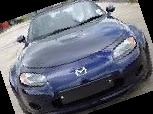

In [4]:
ds['train'][1]['image']

In [5]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['minor', 'moderate', 'severe'], id=None)

In [6]:
ex=ds['train'][0]
labels.int2str(ex['labels'])

'minor'

## Show some data with label

In [41]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):
    w, h = size
    labels = ds['train'].features['labels'].names  # Get class names from ClassLabel
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    
    # Use default PIL font if the specified font is not available
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    for label_id, label in enumerate(labels):  # No need to adjust label_id (starts from 0 with ClassLabel)
        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

# Generate and show examples
example_grid = show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)
example_grid.show()

Filter:   0%|          | 0/5532 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5532 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5532 [00:00<?, ? examples/s]

# Feature Processor

1. Resize
2. Normalize
3. Convert image from PIL to tensors

## Loading ViT Feature Processor

In [7]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [8]:
# Define feature processor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_processor = ViTImageProcessor.from_pretrained(model_name_or_path)

## Transform Dataset

In [9]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [10]:
prepared_ds['train'][1]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': 0}

# Training and Evaluation(ViT-Base)

## Define data collector

In [11]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Define an evaluation metric

In [12]:
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

## Load Pretrained Model

In [41]:
# Load the ViT Model

labels = ds['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Freeze the backbone
for param in model.vit.parameters():
    param.requires_grad = False

# Verify trainable parameters
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable Parameters:", trainable_params)

Trainable Parameters: ['classifier.weight', 'classifier.bias']


In [13]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./vit-final-layer-only",
    per_device_train_batch_size=32,
    eval_strategy="steps",  
    num_train_epochs=10,
    bf16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [44]:
# Initialize Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds['train'],
    eval_dataset=prepared_ds['validation'],
    processing_class=feature_processor
)

In [61]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.010900,1.006869,0.597252
200,0.947200,0.951415,0.616775
300,0.899800,0.914648,0.617498
400,0.888900,0.889270,0.624729
500,0.862000,0.870312,0.631960
600,0.811200,0.855697,0.631236
700,0.845200,0.845433,0.637021
800,0.838200,0.836905,0.640636
900,0.860600,0.829650,0.644975
1000,0.796700,0.824000,0.644252


In [62]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 3992482356GF
  train_loss               =        0.852
  train_runtime            =   1:46:16.02
  train_samples_per_second =        8.676
  train_steps_per_second   =        0.271


# ViT Large

In [40]:
# Define feature processor
model_name_or_path = 'google/vit-large-patch16-224-in21k'
feature_processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [41]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [28]:
# Load the ViT Model

labels = ds['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Freeze the backbone
for param in model.vit.parameters():
    param.requires_grad = False

# Verify trainable parameters
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable Parameters:", trainable_params)

Trainable Parameters: ['classifier.weight', 'classifier.bias']


In [42]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./vit-large-final-layer-only",
    per_device_train_batch_size=32,
    eval_strategy="steps",  
    num_train_epochs=10,
    bf16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [31]:
# Initialize Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds['train'],
    eval_dataset=prepared_ds['validation'],
    processing_class=feature_processor
)

In [69]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.885800,0.887988,0.609544
200,0.800400,0.820570,0.637021
300,0.765200,0.788839,0.639190
400,0.741100,0.768569,0.657267
500,0.739300,0.757946,0.658713
600,0.700300,0.745110,0.668836
700,0.744100,0.738239,0.671005
800,0.722400,0.732531,0.674620
900,0.753600,0.726216,0.681128
1000,0.696000,0.722297,0.678959


In [70]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 14113346154GF
  train_loss               =        0.7364
  train_runtime            =    6:27:57.89
  train_samples_per_second =         2.377
  train_steps_per_second   =         0.074


# Predict on Test Dataset(ViT-base-Final-Layer-Only Model)

In [25]:
model_path = "./vit-final-layer-only"  # Use the path where the model is saved
model = ViTForImageClassification.from_pretrained(model_path)

# Prepare the test dataset
test_dataset = prepared_ds['test']

from copy import deepcopy

# Make a copy of the training arguments and disable eval strategy
predict_args = deepcopy(training_args)
predict_args.eval_strategy = "no"

trainer = Trainer(
    model=model,
    args=predict_args,
    data_collator=collate_fn,
    compute_metrics=None,  # No metrics are needed for prediction
)

In [28]:
# Predict on the test set
results = trainer.predict(prepared_ds['test'])

# Extract predicted probabilities and labels
predicted_probs = torch.sigmoid(torch.tensor(results.predictions)).numpy()  # Apply sigmoid for multi-label
all_labels = results.label_ids

# For single-label classification (argmax for predictions)
predicted_labels = np.argmax(results.predictions, axis=1)

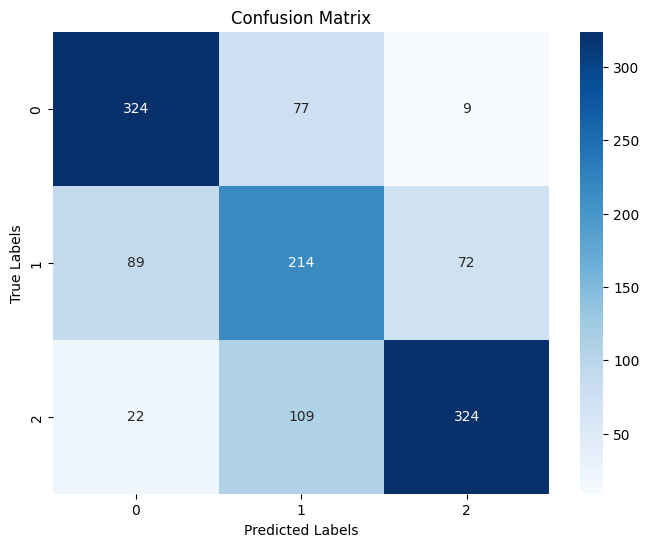

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77       410
           1       0.54      0.57      0.55       375
           2       0.80      0.71      0.75       455

    accuracy                           0.70      1240
   macro avg       0.69      0.69      0.69      1240
weighted avg       0.70      0.70      0.70      1240



In [39]:
# Extract true labels
all_labels = results.label_ids  # True labels should be directly accessible

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, predicted_labels))

# Predict on Test Dataset(Large Model)

!!! Make sure to run the different processor for data first !!!

In [43]:
model_path = "./vit-large-final-layer-only/"  # Use the path where the model is saved
model = ViTForImageClassification.from_pretrained(model_path)

# Prepare the test dataset
test_dataset = prepared_ds['test']

from copy import deepcopy

# Make a copy of the training arguments and disable eval strategy
predict_args = deepcopy(training_args)
predict_args.eval_strategy = "no"

trainer = Trainer(
    model=model,
    args=predict_args,
    data_collator=collate_fn,
    compute_metrics=None,  # No metrics are needed for prediction
)

In [44]:
# Predict on the test set
results = trainer.predict(prepared_ds['test'])

# Extract predicted probabilities and labels
predicted_probs = torch.sigmoid(torch.tensor(results.predictions)).numpy()  # Apply sigmoid for multi-label
all_labels = results.label_ids

# For single-label classification (argmax for predictions)
predicted_labels = np.argmax(results.predictions, axis=1)

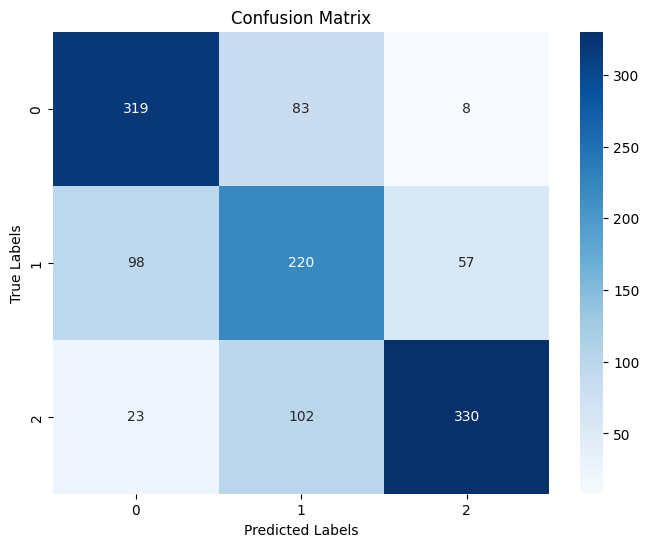

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       410
           1       0.54      0.59      0.56       375
           2       0.84      0.73      0.78       455

    accuracy                           0.70      1240
   macro avg       0.70      0.70      0.70      1240
weighted avg       0.71      0.70      0.70      1240



In [45]:
# Extract true labels
all_labels = results.label_ids  # True labels should be directly accessible

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, predicted_labels))